In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle
import time
import timeit
import h5py
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras


from physionet_processing import (fetch_h5data, spectrogram, 
                                  special_parameters, transformed_stats)

from physionet_processing import (zero_filter, extend_ts, 
                                  random_resample, spectrogram, norm_float)


In [ ]:
#levinthal 
hd_file = "/scratch/thurasx/ecg_project_2/cnn_ecg_keras/physio.h5"
label_file = "/scratch/thurasx/ecg_project_2/cnn_ecg_keras/REFERENCE-v3.csv"
FILENAME = "11"
BINARY = FALSE
# mac 
# hd_file = "/Users/macbookpro/Documents/physio.h5"
# label_file = "/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/REFERENCE-v3.csv"
h5file =  h5py.File(hd_file, 'r')

In [ ]:
# Open hdf5 file


# Get a list of dataset names 
dataset_list = list(h5file.keys())

# Load the labels
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
# Filter the labels that are in the small demo set
label_df = label_df[label_df['name'].isin(dataset_list)]


# Encode labels to integer numbers
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))
labels = dict(zip(label_df.name, label_df.encoded))






In [ ]:
# # Split the IDs in training and validation set
# test_split = 0.44
# idx = np.arange(label_df.shape[0])
# id_train, id_val, _, _ = train_test_split(idx, idx, 
#                                         test_size = test_split,
#                                         shuffle = True,
#                                         random_state = 123)
# val_split = 0.3
# id_val, id_test, _ , _ = train_test_split(id_val, id_val, 
#                                         test_size = val_split,
#                                         shuffle = True,
#                                         random_state = 123)
# # Store the ids and labels in dictionaries
# partition = {'train': list(label_df.iloc[id_train,].name), 
#             'validation': list(label_df.iloc[id_val,].name), 
#             'test': list(label_df.iloc[id_test,].name)}


# print(len(partition['train']))
# print(len(partition['validation']))
# print(len(partition['test']))

4775
2627
1126


In [ ]:


with open(f"/scratch/thurasx/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/cnn_small_{FILENAME}_testlabel.pcl", "rb") as f:
    test_labels = pickle.load(f)

# test_labels = list(label_df.iloc[id_train,].name) + list(label_df.iloc[id_val,].name) + list(label_df.iloc[id_test,].name)
# print(len(test_labels))

In [ ]:
max_length = 18286

# Output dimensions
sequence_length = max_length
spectrogram_nperseg = 64 # Spectrogram window
spectrogram_noverlap = 32 # Spectrogram overlap
n_classes = len(label_df.label.unique())
batch_size = 32

# calculate image dimensions
data = fetch_h5data(h5file, [0], sequence_length)
_, _, Sxx = spectrogram(data, nperseg = spectrogram_nperseg, noverlap = spectrogram_noverlap)
dim = Sxx[0].shape




batch_size= batch_size
dim= dim
nperseg= spectrogram_nperseg
noverlap= spectrogram_noverlap
n_channels= 1
sequence_length= sequence_length
n_classes=n_classes
shuffle= True
data_mean = -9.01
data_std = 9.00

In [ ]:
# Initialization
augment = False
batch_size = len(test_labels)
X = np.empty((batch_size, *dim, n_channels), dtype = float)
y = np.empty((batch_size), dtype = int)
for i, ID in enumerate(test_labels):
    # if i == 10:
    #     break
    data = extend_ts(h5file[ID]['ecgdata'][:, 0], sequence_length)
    data = np.reshape(data, (1, len(data)))

    if augment:
    
        # dropout bursts
        data = zero_filter(data, threshold = 2, depth = 10)
    
        # random resampling
        data = random_resample(data)
    
    # Generate spectrogram
    data_spectrogram = spectrogram(data, nperseg = nperseg, noverlap = noverlap)[2]
    
    # Normalize
    data_transformed = norm_float(data_spectrogram, data_mean, data_std)

    X[i,] = np.expand_dims(data_transformed, axis = 3)
    # print(X[i,].shape)
    # Assuming that the dataset names are unique (only 1 per label)
    y[i] = labels[ID]
    
if BINARY:
    n_classes = 2
    for i, elm in enumerate(y):
        if elm == 0 or elm == 1 or elm == 3:
            y[i] = 0
        elif elm == 2:
            y[i] = 1
# X = X.reshape(batch_size,570,-1)
y = keras.utils.to_categorical(y, num_classes=n_classes)

In [ ]:
# with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/X_test_10_no_aug.pcl" ,"wb") as f:
#     pickle.dump(X, f)


# with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/y_test_10_no_aug.pcl", "wb") as f:
#     pickle.dump(y, f)


In [ ]:
# # print( y [1000])
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))
# plt.imshow(X[1000])
# plt.show()

In [3]:
X_test = X
y_test = y
# with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/X_test_10_no_aug.pcl" , "rb") as f:
#     X_test = pickle.load(f)

# with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/y_test_10_no_aug.pcl", "rb")as f:
#     y_test = pickle.load(f)

In [4]:
print(X_test.shape)
print(y_test.shape)

(8528, 570, 33, 1)
(8528, 4)


In [5]:
# X = np.empty((1, 570, 33, 1), dtype = float)
# X[0,] = X_test[0]

In [6]:
# Load the TFLite model and allocate tensors.
FILENAME = 'full'
interpreter = tf.lite.Interpreter(model_path=f'/scratch/thurasx/ecg_project_2/cnn_ecg_keras/cnn_ecg_keras_tflites/keras_ecg_cnn_small_{FILENAME}.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)
# print(input_shape.reshape(570,33,1))


[  1 570  33   1]


In [7]:
# inference
ret_results = []
for i,data in enumerate(X_test):  
    # print(data[i].reshape(540,33))
    # data = data.reshape(1,540,33,1)
    
    X = np.empty((1, 570, 33, 1), dtype = float)
    X[0,] = data
    start = timeit.timeit()
    input_data = X.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    end = timeit.timeit()
    ret_results.append([start, end, y_test[i].argmax(), output_data.argmax()])

# print(ret_results)
# with open(f"/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/small_{FILENAME}_results.pcl", "wb") as f:
#     pickle.dump(ret_results, f)

Accuracy:  0.6212476547842402


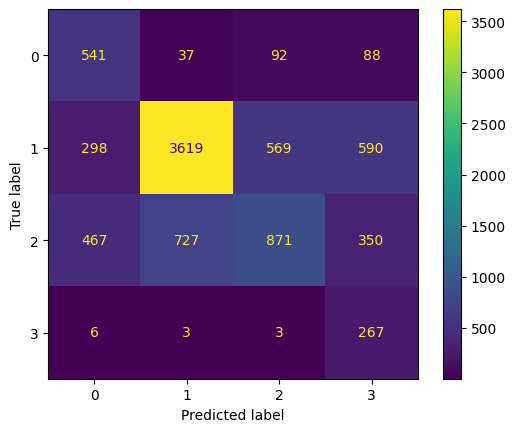

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

y_pred = [i[3] for i in ret_results]
y_true = [i[2] for i in ret_results]
print("F1 score: ", f1_score(y_true, y_pred, average='weighted'), FILENAME)
print("Accuracy: ", accuracy_score(y_true, y_pred), "Name: ", FILENAME)
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()